# Customer Loyalty Prediction 1: Data Cleaning and EDA

[Elo](https://elo.com.br/) is a Brazillian debit and credit card brand.  They offer credit and prepaid transactions, and have paired up with merchants in order offer promotions to cardholders.  In order to offer more relevant and personalized promotions, in a [recent Kaggle competition](https://www.kaggle.com/c/elo-merchant-category-recommendation), Elo challenged Kagglers to predict customer loyalty based on transaction history.  Presumably they plan to use a loyalty-predicting model in order to determine what promotions to offer to customers based on how certain offers are predicted to effect card owners' card loyalty.

In this post, we'll load, clean, and explore the raw data from the [Elo Merchant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) challenge.  The name of the challenge is a bit misleading, seeing as the immediate goal is to predict customer loyalty - not to recommend merchants to card owners.  In future posts, we'll work on [feature engineering, feature selection](http://www.kaggle.com/brendanhasz/elo-feature-engineering-and-feature-selection), [modeling](https://www.kaggle.com/brendanhasz/elo-modeling), and understanding our model's predictions.

**Outline**

- [Data Loading and Cleaning](#data-loading-and-cleaning)
  - [Cards Data](#cards-data)
  - [Mismatch between Merchants and Transactions Data](#mismatch-between-merchants-and-transactions-data)
  - [Merchants Data](#merchants-data)
  - [Transactions Data](#transactions-data)
- [Exploratory Data Analysis](#exploratory-data-analysis)
  - [Cards](#cards)
  - [Merchants](#merchants)
  - [Transactions](#transactions)
- [Conclusion](#conclusion)

Let's first load the packages we'll use:

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import gc

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

In [2]:
!pip install git+http://github.com/brendanhasz/dsutils.git

  Cloning http://github.com/brendanhasz/dsutils.git to /tmp/pip-req-build-zv2rb1mv
  Stored in directory: /tmp/pip-ephem-wheel-cache-j7d4acfm/wheels/a1/ff/2a/75bdc08e9c96d4917294db5e6faf99ef3de673f37992c52278
Successfully built dsutils
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from dsutils.printing import print_table, describe_df
from dsutils.eda import countplot2d

<a id='data-loading-and-cleaning'></a>
## Data Loading and Cleaning

There are 5 different data tables in the Elo dataset:

* `train.csv`
* `test.csv`
* `merchants.csv`
* `historical_transactions.csv`
* `new_merchant_transactions.csv`

The first file (`train.csv`) contains information about the credit card accounts and the loyalty score for each.  `test.csv` contains the same information, but about different accounts, and it does not contain loyalty scores - because those are the accounts for which we are trying to predict the loyalty!  `merchants.csv` has information about the merchants where the credit cards are being used to make transactions.  Finally, the `historical_transactions.csv` and `new_merchant_transactions.csv` files contain lists of all the individual transactions which were made between the credit cards and the merchants, and some features of those transactions (time and date, purchase amount, etc).

Eventually, we'll want to build a predictive model, train it on the cards data in `train.csv` and the information in the merchants and transactions datasets associated with those cards, and then predict the loyalty scores for the cards in `test.csv` (using the data in the merchants and transactions datasets associated with cards in `test.csv`).  But first, we need to load and clean the data!

<a id='cards-data'></a>
### Cards Data

Let's start by taking a look at the cards dataset, which contains information about the credit card accounts for which we'll be predicting the loyalty score.  There are two files (`test.csv` and `train.csv`) which contain information about the cards - the only difference is that `train.csv` has the loyalty score for each card, while `test.csv` doesn't (because we are going to try to predict the loyalty score for those accounts).  Let's load both the files:

In [4]:
# Load card data
dtypes = {
  'card_id':            'str',
  'target':             'float32',
  'first_active_month': 'str',
  'feature_1':          'uint8',
  'feature_2':          'uint8',
  'feature_3':          'uint8',
}
train = pd.read_csv('../input/train.csv',
                    usecols=dtypes.keys(),
                    dtype=dtypes)
del dtypes['target']
test = pd.read_csv('../input/test.csv',
                   usecols=dtypes.keys(),
                   dtype=dtypes)

There are no nulls anywhere in `train.csv`:

In [5]:
describe_df(train)

Rows:    201917
Columns: 6
Memory usage: 4644171 Bytes
Column              Dtype    Nulls  Min              Mean      Max              Mode             Uniques             
first_active_month  object   0      2011-11                    2018-02          2017-09          75 unique values    
card_id             object   0      C_ID_00007093c1            C_ID_fffffd5772  C_ID_00007093c1  201917 unique values
feature_1           uint8    0      1                3.1053    5                3                [5 4 2 1 3]         
feature_2           uint8    0      1                1.7454    3                1                [2 1 3]             
feature_3           uint8    0      0                0.56557   1                1                [1 0]               
target              float32  0      -33.21928        -0.39363  17.965069                         196910 unique values


But, there is a *single row* in `test.csv` which has a null value in the `first_active_month` column:

In [6]:
describe_df(test)

Rows:    123623
Columns: 5
Memory usage: 2348917 Bytes
Column              Dtype   Nulls  Min              Mean     Max              Mode             Uniques             
first_active_month  object  1      2011-11                   2018-01          2017-09          75 unique values    
card_id             object  0      C_ID_0001238066           C_ID_ffff756266  C_ID_0001238066  123623 unique values
feature_1           uint8   0      1                3.1093   5                3                [3 2 5 1 4]         
feature_2           uint8   0      1                1.7418   3                1                [3 1 2]             
feature_3           uint8   0      0                0.56438  1                1                [1 0]               


To ensure we process the test and training data identically, we'll merge them into a single dataframe called `cards`.  Since the test dataset has no `target` values (the loyaly score we are trying to predict), we'll set the target to NaN for the test data.

In [7]:
# Add target col to test
test['target'] = np.nan

# Merge test and train
cards = pd.concat([train, test])

As a quick sanity check, let's make sure there aren't any `card_id`s which are in both test and train:

In [8]:
print('Num unique in train:  ', test['card_id'].nunique())
print('Num unique in test:   ', train['card_id'].nunique())
print('The sum:              ', test['card_id'].nunique()+train['card_id'].nunique())
print('Num unique in merged: ', cards['card_id'].nunique())

Num unique in train:   123623
Num unique in test:    201917
The sum:               325540
Num unique in merged:  325540


OK good, there aren't. Now we can delete the original dataframes.

In [9]:
del train, test
gc.collect()

99

Let's take a look at the cards data.

In [10]:
cards.sample(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
157085,2017-05,C_ID_f7620bfd94,5,2,1,-0.944633
100291,2017-01,C_ID_fc038df613,5,2,1,NaN
72889,2016-08,C_ID_80f644abe8,2,2,0,2.219103
94558,2016-06,C_ID_a32d57c74a,3,3,1,NaN
150168,2017-09,C_ID_05968065ba,3,1,1,0.212414
57073,2017-11,C_ID_f9d5aef340,3,1,1,NaN
31214,2017-07,C_ID_5dd33072d1,2,1,0,NaN
34841,2017-06,C_ID_4c4d658411,3,3,1,-0.564256
160211,2017-04,C_ID_73aa6a139c,2,1,0,-0.806128
146742,2017-07,C_ID_17479ffeb8,5,2,1,-0.335772


The `card_id`s always start with `C_ID_`. That's kind of a waste of space... All the `card_id`s are the same length:

In [11]:
cards['card_id'].apply(len).unique()

array([15])

If we cut off the prefix, the remaining strings appear to be all hexidecimal (represented by values 0-9 and a-f):

In [12]:
cards['card_id'].str.slice(5, 15).sample(10)

61268     7a85fe379e
87608     ba120cc914
79900     bf460be950
37646     0c57e722ae
38417     87d10cf481
114345    a528776c17
28305     dc9832c8ff
175337    914f7aff24
113188    9847bbc26c
12142     51547dc41a
Name: card_id, dtype: object

But let's check that this is the case for every entry:

In [13]:
(cards['card_id']
 .str.slice(5, 15)
 .apply(lambda x: all(e in '0123456789abcdef' for e in x))
 .all())

True

Indeed all the `card_id`s are hexidecimal.  To save space, we could convert the `card_id`s to integers like this:

In [14]:
#cards['card_id'] = cards['card_id'].apply(lambda x: int(x, 16))

There are 5 bytes worth of hex info in the card ids (each hexideximal digit represents 4 bits, so the 10 hexideximal digits in the card ids represent 40 bits = 5 bytes of information).  Inconveniently, the values span the full 5-byte range - so, we'd have to use a 64-bit integer to represent them (which is 8 bytes, instead of a 32-bit int, which is only 4 bytes).  However, that would be a waste of space, seeing as there are only 325,540 unique card_ids, and could easily be represented in 4 bytes by a uint32 (which stores values up to ~4 billion). The inneficiency of using a 64-bit representation for something where a 32-bit reprentation would do... Bothers me. *eye twitches*

To use a 32-bit integer, we'll create a map between the card_id and a unique integer which identifies it, and then map the string values to integer values.

In [15]:
# Create a map from card_id to unique int
card_id_map = dict(zip(
    cards['card_id'].values,
    cards['card_id'].astype('category').cat.codes.values
))

# Map the values
cards['card_id'] = cards['card_id'].map(card_id_map).astype('uint32')

Now our `card_id`s are 32-bit integers:

In [16]:
cards.sample(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
21160,2016-04,35174,5,1,1,NaN
8465,2017-09,100859,4,3,0,NaN
107372,2017-08,105376,5,1,1,-0.598433
91952,2017-09,246942,2,1,0,3.186677
150075,2017-04,29699,3,3,1,-1.374764
199280,2017-08,46327,1,1,0,-0.038083
39293,2015-08,111409,5,1,1,-0.504486
67663,2016-12,234425,3,2,1,NaN
115331,2015-10,292146,2,1,0,3.645835
20158,2017-06,70659,5,1,1,0.257987


Next, we'll convert the `first_active_month` from a string to a datetime.

In [17]:
# Convert first_active_month to datetime
cards['first_active_month'] = pd.to_datetime(cards['first_active_month'],
                                             format='%Y-%m')

Finally, we'll set the index to be the `card_id`.

In [18]:
# Make card_id the index
cards.set_index('card_id', inplace=True)
gc.collect()
cards.sample(10)

,first_active_month,feature_1,feature_2,feature_3,target
card_id,,,,,
214021,2016-09-01,5,2,1,NaN
314730,2016-11-01,5,2,1,-0.831519
80085,2017-08-01,2,1,0,NaN
175144,2017-10-01,2,3,0,NaN
230176,2016-12-01,5,2,1,NaN
322649,2017-10-01,3,1,1,2.719444
128288,2017-10-01,3,1,1,NaN
43638,2017-02-01,3,2,1,-1.392665
313044,2017-04-01,5,2,1,0.094851


<a id='mismatch-between-merchants-and-transactions-data'></a>
### Mismatch between Merchants and Transactions Data

Both the transactions data (`historical_transactions.csv` and `new_merchant_transactions.csv`) and the merchants data (`merchants.csv`)  have the following columns:

* `city_id`
* `state_id`
* `category_1`
* `category_2`
* `subsector_id`
* `merchant_category_id`, and
* `merchant_id`

Obviously we want them both to have `merchant_id` so that we can connect the tables, but it's unclear whether the other columns in the transactions table represent information about the *merchant* or the *transaction*.  It seems that `merchant_category_id` and `subsector_id` at least should definitely represent information about the merchant, and therefore should be the same between transactions involving the same `merchant_id`, and should also match the information in `merchants.csv`.  If `city_id` and `state_id` represent, say, the corporate mailing address of the merchant, then those should also remain constant.  On the other hand, if they represent the city and state where the transaction occurred, there may be many different values for the same `merchant_id`.  Since `category_1` and `category_2` are in both datasets, it seems likely that they also represent information about the merchant.

However, let's verify whether that's true.  First let's load only the columns of interest:

In [19]:
# Datatypes of each column
dtypes = {
    'city_id':              'int16', 
    'category_1':           'str',
    'merchant_category_id': 'int16',
    'merchant_id':          'str',
    'category_2':           'float16',
    'state_id':             'int8',
    'subsector_id':         'int8'
}

# Load the data
hist_trans = pd.read_csv('../input/historical_transactions.csv', 
                         usecols=dtypes.keys(),
                         dtype=dtypes)
new_trans = pd.read_csv('../input/new_merchant_transactions.csv', 
                        usecols=dtypes.keys(),
                        dtype=dtypes)
merchants = pd.read_csv('../input/merchants.csv', 
                        usecols=dtypes.keys(),
                        dtype=dtypes)

# Merge new_merchant and historical transactions
trans = pd.concat([hist_trans, new_trans])
del hist_trans
del new_trans
gc.collect()

0

Then we can check that the values of `city_id`, `state_id`, `category_1`, `category_2`, `subsector_id`, and `merchant_category_id` match between transactions which have the same `merchant_id`.

In [20]:
# For each column, count merchant_ids w/ >1 unique vals
gbo = trans.groupby('merchant_id')
nuniques = []
cols = []
for col in trans:
    if col == 'merchant_id': continue
    nuniques.append((gbo[col].nunique() > 1).sum())
    cols.append(col)
print_table(['Column', 'Number unique'], 
            [cols, nuniques])

Column                Number unique
city_id               25207        
category_1            3494         
merchant_category_id  82636        
category_2            7844         
state_id              17435        
subsector_id          44373        


Hmm, there's a bunch of mismatches.  A sizeable chunk of the merchants (there are only ~335,000) have features which change in the transactions data.  How many of the transactions have merchant-specific values which don't match the data in the merchants table?

In [21]:
# Join trans w/ merchants on merchant_id

# Check that all feature_transactions==feature_merchants
df = trans.merge(merchants, how='outer', on='merchant_id', 
                 suffixes=('', '_merchants'))
cols = []
mismatches = []
for col in trans:
    if 'merchant_id' in col: continue
    sames = ((df[col] == df[col+'_merchants']) | 
             (df[col].isnull() & df[col+'_merchants'].isnull())).sum()
    cols.append(col)
    mismatches.append(df.shape[0]-sames)

# Print the number of mismatches
print_table(['Column', 'Num mismatches'],
            [cols, mismatches])
print('Total number of transactions: ', df.shape[0])

# Clean up
del trans, merchants, df, sames
gc.collect()

Column                Num mismatches
city_id               9556796       
category_1            3320439       
merchant_category_id  5312999       
category_2            4428102       
state_id              4538880       
subsector_id          4084017       
Total number of transactions:  32328675


35

So, it appears that there is a pretty respectable mismatch between the merchant-specific values in the transactions data and in the merchants data.  This is probably because the merchant's properties may have *changed* in the time between the transaction and the time the merchants dataset was compiled.  Therefore, we'll use the values in the transactions table (and not the values in the merchants table) when creating features for our predictive model, because the values in the transactions table are more likely to reflect the merchant at the time when it was important - when the transaction occurred.

<a id='merchants-data'></a>
### Merchants Data

Again, the merchants dataset (in `merchants.csv`) contains information about the merchants which card owners are making transactions with.  Let's load the data, but because of the overlap with the transactions data just discussed, we won't load the columns which are in the transactions datasets.

In [22]:
# Datatypes of each column
# (don't load cols which are in transactions data)
dtypes = {
  'merchant_id':                 'str',
  'merchant_group_id':           'uint32',
  'numerical_1':                 'float32',
  'numerical_2':                 'float32',
  'most_recent_sales_range':     'str',
  'most_recent_purchases_range': 'str',
  'avg_sales_lag3':              'float32',
  'avg_purchases_lag3':          'float32',
  'active_months_lag3':          'uint8',
  'avg_sales_lag6':              'float32',
  'avg_purchases_lag6':          'float32',
  'active_months_lag6':          'uint8',
  'avg_sales_lag12':             'float32',
  'avg_purchases_lag12':         'float32',
  'active_months_lag12':         'uint8',
  'category_4':                  'str',
}

# Load the data
merchants = pd.read_csv('../input/merchants.csv',
                        usecols=dtypes.keys(),
                        dtype=dtypes)

Let's take a look at the merchants data.

In [23]:
merchants.sample(10)

,merchant_id,merchant_group_id,numerical_1,numerical_2,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4
300156,M_ID_672824acf9,6398,-0.047556,-0.057471,C,D,0.81,0.847458,3,0.78,0.851897,6,0.83,0.902542,12,N
280389,M_ID_faa12cf31c,71602,-0.057471,-0.057471,D,D,0.93,0.890710,3,0.87,0.893833,6,0.79,0.876659,12,N
13973,M_ID_3712d59b36,522,-0.057471,-0.057471,E,E,1.67,1.428571,3,1.46,1.285714,6,1.80,1.363095,12,N
277377,M_ID_1560537636,38420,-0.057471,-0.057471,D,D,1.00,1.022750,3,0.98,1.005440,6,1.13,1.191395,12,Y
70529,M_ID_7b8fc150b2,49062,-0.057471,-0.057471,E,E,0.94,0.757576,3,1.16,0.939394,6,1.67,1.030303,12,N
237630,M_ID_1cd07a1a61,56276,-0.057471,-0.057471,D,D,0.83,0.922572,3,0.71,0.817585,6,0.69,0.783465,12,N
74150,M_ID_471a70cd8a,19423,-0.057471,-0.057471,E,E,0.92,0.722222,3,0.90,0.694444,6,0.60,0.500000,12,N
309558,M_ID_9963bbcb5f,102379,-0.057471,-0.057471,C,D,1.05,0.969250,3,1.18,1.021525,6,1.21,1.039668,12,Y
95991,M_ID_608eb06505,15827,-0.057471,-0.057471,E,E,1.22,1.333333,3,1.22,1.333333,3,1.22,1.333333,3,N
108380,M_ID_14405a24b7,49481,-0.057471,-0.057471,E,E,1.02,0.907407,3,1.15,1.141975,6,1.21,1.158951,12,N


We'll map the `merchant_id`s to integers like we did for the `card_id`s.  We'll also transform some columns to be more manageable, and encode categorical columns to integers.

In [24]:
# Map merchant_id to integer
merch_id_map = dict(zip(
    merchants['merchant_id'].values,
    merchants['merchant_id'].astype('category').cat.codes.values
))

In [25]:
def preprocess_merch_data(df):
    
    # Convert merchant ID to numbers
    df['merchant_id'] = df['merchant_id'].map(merch_id_map).astype('float32')

    # Inverse transforms
    inversions = [
        'avg_sales_lag3',
        'avg_sales_lag6',
        'avg_sales_lag12',
        'avg_purchases_lag3',
        'avg_purchases_lag6',
        'avg_purchases_lag12',
    ]
    for col in inversions:
        df[col] = 1.0/df[col]

    # Encode categorical columns
    bool_map = {'Y': 1, 'N': 0}
    five_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    conversions = [
        ('category_4', bool_map, 'uint8'),
        ('most_recent_sales_range', five_map, 'uint8'),
        ('most_recent_purchases_range', five_map, 'uint8')
    ]
    for col, mapper, new_type in conversions:
        df[col] = df[col].map(mapper).astype(new_type)
        
    # Clean up
    gc.collect()

# Preprocess the merchants data
preprocess_merch_data(merchants)

There are no duplicate rows in the merchants dataset:

In [26]:
print("Number of duplicate rows in merchants.csv: %d" 
      % merchants.duplicated().sum())

Number of duplicate rows in merchants.csv: 0


But, there are duplicate `merchant_id`s:

In [27]:
print("Number of duplicate merchant_ids: %d" % 
      merchants['merchant_id'].duplicated().sum())

Number of duplicate merchant_ids: 63


Let's take a look at some of the duplicate entries to see which ones look like they should be removed.

In [28]:
# Show some of the duplicates
duplicates = merchants['merchant_id'].duplicated(keep=False)
merchants[duplicates].sort_values('merchant_id').head(6)

,merchant_id,merchant_group_id,numerical_1,numerical_2,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4
111,307.0,35,-0.057471,-0.057471,4,4,1.515151,1.500000,3,1.515151,1.500000,3,1.515151,1.500000,3,1
112,307.0,35,0.408530,0.408530,2,3,0.854701,0.901186,3,0.854701,0.919170,6,0.840336,1.002988,12,1
110970,854.0,35,-0.057471,-0.057471,0,0,1.075269,1.053421,3,1.162791,1.147823,6,1.315789,1.328655,12,1
110969,854.0,35,-0.047556,-0.057471,4,4,0.144300,0.078708,3,0.118765,0.063069,6,0.116686,0.061653,7,1
70494,10108.0,35,0.031763,0.031763,4,4,0.793651,0.875486,3,0.833333,0.797872,6,0.869565,0.791872,12,0
70493,10108.0,35,-0.057471,-0.057471,4,4,1.000000,1.000000,1,1.000000,1.000000,1,1.000000,1.000000,1,0


Unfortunately it's not super clear which of the entries is invalid, outdated, or incomplete.  If one entry had empty values and another didn't then we could just remove the entry with empty values.  As it is, we'll just remove all duplicate entries but the first.

In [29]:
# Drop duplicate entries
merchants.drop_duplicates(subset='merchant_id',
                          keep='first', inplace=True)

<a id='transactions-data'></a>
### Transactions Data

The transactions datasets contain information about transactions which card owners have made with the merchants in the merchants dataset.  `historical_transactions.csv` contains historical transactions (transactions since the card account was opened), while `new_merchant_transactions.csv` contains information about transactions during the period before the loyalty score was calculated.

In order to make predictions about the loyalty of card owners, we'll have to use their transaction histories to come up with informative features about each customer.  But, before we can do that, we have to load and clean the data!  

Since there are many transactions per customer (or per merchant), the transactions datasets are much larger than the cards and merchants datasets.  We've been doing this the whole time, but this is really where it helps a lot - specifying the datatypes to use for each column when calling panda's `read_csv` really speeds up the loading of the data.  Let's load the historical and new transactions using this method.

In [30]:
# Datatypes of each column
dtypes = {
    'authorized_flag':      'str',
    'card_id':              'str',
    'city_id':              'int16',
    'category_1':           'str',
    'installments':         'int8',
    'category_3':           'str',
    'merchant_category_id': 'int16',
    'merchant_id':          'str',
    'month_lag':            'int8',
    'purchase_amount':      'float32',
    'purchase_date':        'str',
    'category_2':           'float32',
    'state_id':             'int8',
    'subsector_id':         'int8',
}

# Load the data
hist_trans = pd.read_csv('../input/historical_transactions.csv', 
                         usecols=dtypes.keys(),
                         dtype=dtypes)
new_trans = pd.read_csv('../input/new_merchant_transactions.csv', 
                        usecols=dtypes.keys(),
                        dtype=dtypes)

We also need to convert the `card_id` to an integer as before, `merchant_id` to an integer in the same way, convert the `purchase_date` column (which has been loaded as a string) to datetime format, and encode the categorical columns.

In [31]:
def preprocess_trans_data(df):
    
    # Convert card_id and merchant_id to numbers
    df['card_id'] = df['card_id'].map(card_id_map).astype('uint32')
    df['merchant_id'] = df['merchant_id'].map(merch_id_map).astype('float32')

    # Convert purchase_date to datetime
    df['purchase_date'] = df['purchase_date'].str.slice(0, 19)
    df['purchase_date'] = pd.to_datetime(df['purchase_date'],
                                         format='%Y-%m-%d %H:%M:%S')

    # Encode categorical columns
    bool_map = {'Y': 1, 'N': 0}
    three_map = {'A': 0, 'B': 1, 'C': 2}
    conversions = [
        ('authorized_flag', bool_map, 'uint8'),
        ('category_1', bool_map, 'uint8'),
        ('category_3', three_map, 'float32'), #has NaNs so have to use float
    ]
    for col, mapper, new_type in conversions:
        df[col] = df[col].map(mapper).astype(new_type)
        
    # Clean up
    gc.collect()

# Preprocess the transactions data
preprocess_trans_data(hist_trans)
preprocess_trans_data(new_trans)

However, there are a few funky (yet valid) values in the dataset.  Taking a quick view at the dataframe, there are a  few value which are odd:

In [32]:
describe_df(hist_trans)

Rows:    29112361
Columns: 14
Memory usage: 1106269798 Bytes
Column                Dtype           Nulls    Min                  Mean        Max                  Mode   Uniques               
authorized_flag       uint8           0        0                    0.91355     1                    1      [1 0]                 
card_id               uint32          0        0                    1.6251e+05  325539               78027  325540 unique values  
city_id               int16           0        -1                   129.33      347                  69     308 unique values     
category_1            uint8           0        0                    0.071586    1                    0      [0 1]                 
installments          int8            0        -25                  0.64188     12                   0      15 unique values      
category_3            float32         178159   0.0                  0.53111     2.0                         [0. 1. 2.]            
merchant_category_id  

There are values of -1 in the `city_id`, `installments`, and `state_id` columns, while the vast majority of the features' ranges are non-negative.  Especially for `installments`: it makes no sense to have a negative number of payment installments.  Let's look at the distribution of these column individually.  Starting with `installments`:

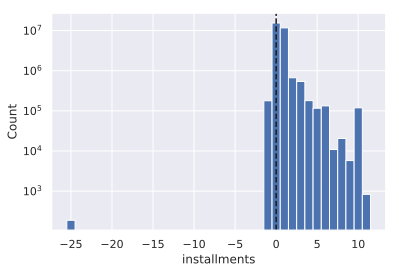

In [33]:
# Histogram of installments
plt.hist(hist_trans['installments'],
         bins=np.arange(-25.5, 12.5, 1.0))
plt.axvline(x=0, color='k', linestyle='--')
plt.ylabel('Count')
plt.xlabel('installments')
plt.yscale('log', nonposy='clip')
plt.show()

Hmm, values of -1 and -25?  Those are probably to indicate missing values, so we'll set the installments with negative numbers to NaN:

In [34]:
# Set negative installments to nan
hist_trans.loc[hist_trans['installments']<0, 'installments'] = np.nan
new_trans.loc[new_trans['installments']<0, 'installments'] = np.nan

There's a similar problem for `city_id` and `state_id`:

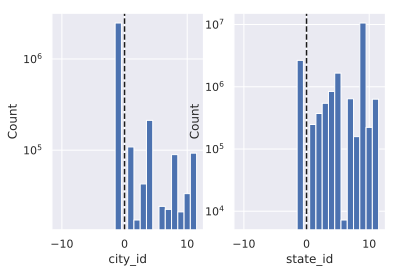

In [35]:
# Histogram of city_id and state_id
plt.subplot(121)
plt.hist(hist_trans['city_id'],
         bins=np.arange(-10.5, 12.5, 1.0))
plt.axvline(x=0, color='k', linestyle='--')
plt.ylabel('Count')
plt.xlabel('city_id')
plt.yscale('log', nonposy='clip')

plt.subplot(122)
plt.hist(hist_trans['state_id'],
         bins=np.arange(-10.5, 12.5, 1.0))
plt.axvline(x=0, color='k', linestyle='--')
plt.ylabel('Count')
plt.xlabel('state_id')
plt.yscale('log', nonposy='clip')

plt.show()

We'll set those to NaN too, seeing as they likely indicate missing values.

In [36]:
# Set negative ids to nan
hist_trans.loc[hist_trans['city_id']<0, 'city_id'] = np.nan
new_trans.loc[new_trans['city_id']<0, 'city_id'] = np.nan
hist_trans.loc[hist_trans['state_id']<0, 'state_id'] = np.nan
new_trans.loc[new_trans['state_id']<0, 'state_id'] = np.nan

<a id='exploratory-data-analysis'></a>
## Exploratory Data Analysis

Now that we've loaded and cleaned the data, let's do some EDA!

<a id='cards'></a>
### Cards

The cards dataset (split into `test.csv` and `train.csv`) contain information about the credit card accounts for which we're trying to predict the customer loyalty.  Pretty much all this dataset contains is the card ID, the loyalty score, the month the account was first active, and three anonymized categorical features.

In [37]:
describe_df(cards)

Rows:    325540
Columns: 5
Memory usage: 7487420 Bytes
Column              Dtype           Nulls   Min                  Mean      Max                  Mode  Uniques             
first_active_month  datetime64[ns]  1       2011-11-01 00:00:00            2018-02-01 00:00:00        76 unique values    
feature_1           uint8           0       1                    3.1068    5                    3     [5 4 2 1 3]         
feature_2           uint8           0       1                    1.744     3                    1     [2 1 3]             
feature_3           uint8           0       0                    0.56512   1                    1     [1 0]               
target              float32         123623  -33.21928            -0.39363  17.965069                  196910 unique values


Let's start by taking a look at the distribution of loyalty scores, which is the target variable we'll be trying to predict when we build a predictive model.

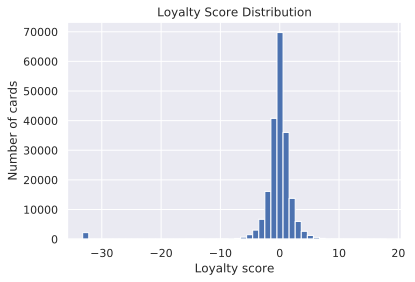

In [38]:
# Loyalty score (aka the target)
cards['target'].hist(bins=50)
plt.xlabel('Loyalty score')
plt.ylabel('Number of cards')
plt.title('Loyalty Score Distribution')
plt.show()

Yikes.  The first, most obvious thing is those outliers at around -32.  About 1% of the training data have these outlier values:

In [39]:
print('Percent of cards with values <20: %0.3f'
      % (100*(cards['target']<-20).sum() /
              cards['target'].notnull().sum()))

Percent of cards with values <20: 1.093


And all of these outlier values are exactly the same:

In [40]:
cards.loc[cards['target']<-20, 'target'].unique()

array([-33.21928024])

Those outliers are definitely something we'll have to pay attention to when building a predictive model.  With a normal linear model (like, say, a non-robust linear regression) the outliers would have an enormus effect on the model.  We might want to perform some kind of outlier detection and train a separate model only on non-outlier data.

Another thing to note is the shape of the distribution - it's not normally distributed (the tails are too heavy and the central part is too sharp).  To me, it looks more like a log ratio distribution:

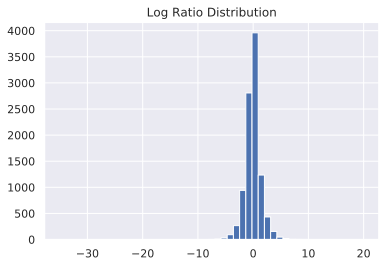

In [41]:
# Show a log ratio distribution
a = np.random.rand(10000)
b = np.random.rand(10000)
c = np.log(a/b)
plt.hist(c, bins=np.linspace(-35, 20, 50))
plt.title('Log Ratio Distribution')
plt.show()

This suggests that the loyalty score may actually be the log of the ratio of two numbers, for example "number of new purchases" to "number of historical purchases".  The outlier values then may be cases when the denominator was zero.  Since the log of zero is negative infinity, a small positive number may have been added to the denominator to prevent infinite loyalty scores.  A small number like `1e-14` ends up being pretty close to the outlier values when the log is taken:

In [42]:
np.log(1e-14)

-32.23619130191664

The cards dataset also contains the month in which the account was first active.  Looking at the distribution for that variable, we can see a progressive ramping up of the number of cards, with peaks just before the new year.

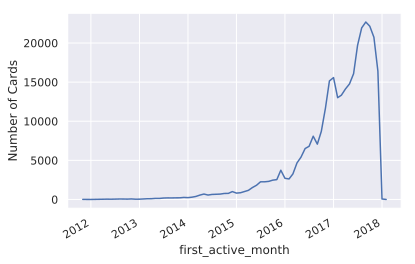

In [43]:
# Plot first_active_month distribution
fam = cards['first_active_month'].value_counts()
fam.plot()
plt.ylabel('Number of Cards')
plt.xlabel('first_active_month')
plt.show()

We can also look at the loyalty score (our target variable) as a function of the month the account was first active.  The confidence intervals in the plot below shrink the closer we get to 2018, because there are more samples at later timepoints (which you can see in the plot above).  There doesn't seem to be a huge change in the loyalty score as a function of first active month, except perhaps a slight uptick in loyalty scores over the course of 2017.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


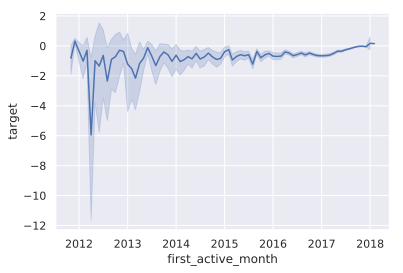

In [44]:
# first_active_month vs loyalty score
sns.lineplot(x='first_active_month', y='target', data=cards)
plt.show()

Lastly, the cards dataset contains three categorical columns (with intentionally obfuscated titles): `feature_1`, `feature_2`, and `feature_3`.

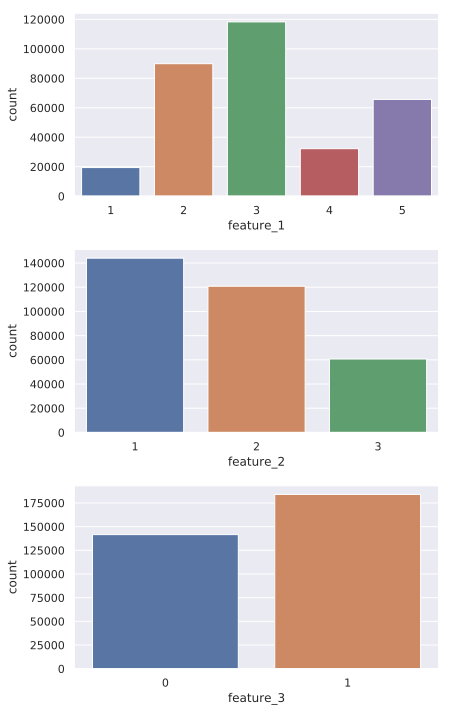

In [45]:
# category counts
plt.figure(figsize=(6.4, 10))
plt.subplot(311)
sns.countplot(x='feature_1', data=cards)
plt.subplot(312)
sns.countplot(x='feature_2', data=cards)
plt.subplot(313)
sns.countplot(x='feature_3', data=cards)
plt.tight_layout()
plt.show()

The three categorical distributions are reasonably well-balanced (at least, the categories all have within an order of magnitude of occurrences).  

If we look at the loyalty score (the target variable) as a function of these categories, it appears that there are small differences in the loyalty score as all three of the category values increase (except perhaps when `feature_2`=2).

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


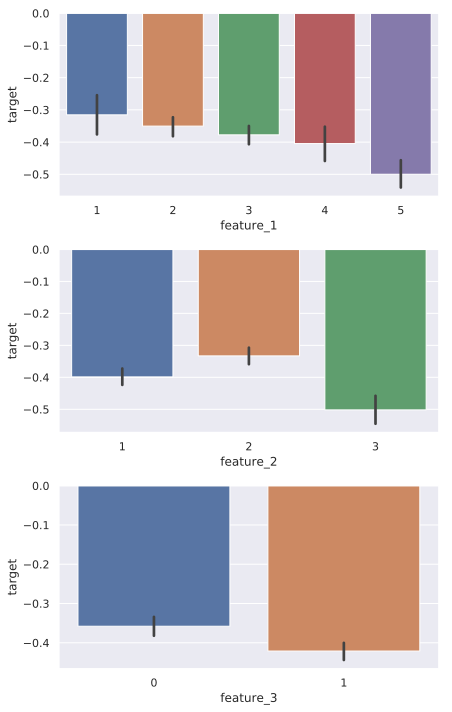

In [46]:
# Features vs loyalty score with std dev
plt.figure(figsize=(6.4, 10))
plt.subplot(311)
sns.barplot(x='feature_1', y='target', data=cards)
plt.subplot(312)
sns.barplot(x='feature_2', y='target', data=cards)
plt.subplot(313)
sns.barplot(x='feature_3', y='target', data=cards)
plt.tight_layout()
plt.show()

However, the error bars plotted above are the estimated confidence intervals of the mean - the standard deviations are much larger.  If we set the error bars to show the standard deviation, we can see the raw variance in the data is huge compared to the differences between categories:

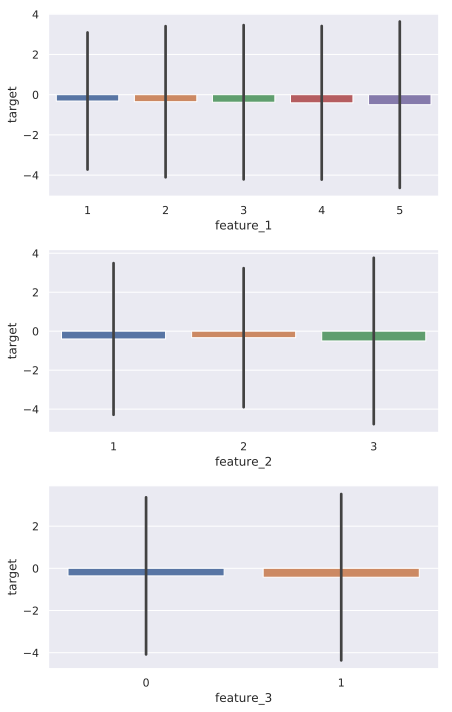

In [47]:
# Features vs loyalty score with std dev
plt.figure(figsize=(6.4, 10))
plt.subplot(311)
sns.barplot(x='feature_1', y='target',
            data=cards, ci='sd')
plt.subplot(312)
sns.barplot(x='feature_2', y='target',
            data=cards, ci='sd')
plt.subplot(313)
sns.barplot(x='feature_3', y='target',
            data=cards, ci='sd')
plt.tight_layout()
plt.show()

<a id='merchants'></a>
### Merchants

The merchants dataset has information about every merchant that any credit card account made a transaction with.  Now that we've cleaned and loaded that dataset, let's take a look again at the basic information about each column.

In [48]:
describe_df(merchants)

Rows:    334633
Columns: 16
Memory usage: 26101374 Bytes
Column                       Dtype    Nulls  Min          Mean        Max        Mode  Uniques             
merchant_id                  float32  0      0.0          1.6732e+05  334632.0         334633 unique values
merchant_group_id            uint32   0      1            31033       112586     35    109389 unique values
numerical_1                  float32  0      -0.05747065  0.010345    183.7351         949 unique values   
numerical_2                  float32  0      -0.05747065  0.0070865   182.07932        941 unique values   
most_recent_sales_range      uint8    0      0            3.3885      4          4     [4 3 2 1 0]         
most_recent_purchases_range  uint8    0      0            3.3828      4          4     [4 3 2 1 0]         
avg_sales_lag3               float64  13     -2.5         1.0017      3.0303           3372 unique values  
avg_purchases_lag3           float64  0      0            0.97086     2.9985   

The `merchant_group_id` column contains what group the merchant belongs to.  Presumably this corresponds to a business group (e.g. "Walmart", and individual merchants are individual stores), and not some sort of business sector identifier.  One single group has around 50,000 merchants in it, and around 3,000 have >10 merchants, but most have less than 10:

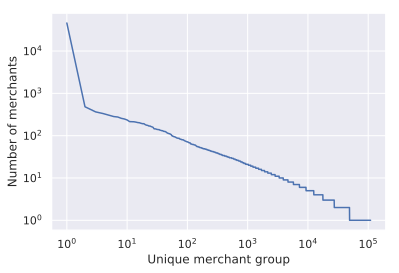

In [49]:
# Show number of merchants per merchant group
mpmg = merchants['merchant_group_id'].value_counts().values
plt.plot(np.arange(len(mpmg))+1, mpmg)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Unique merchant group')
plt.ylabel('Number of merchants')
plt.show()

The merchants dataset also contains two anonymized features: `numerical_1` and `numerical_2`.  The two distributions are very similar and are both very skewed (notice the log Y axis).

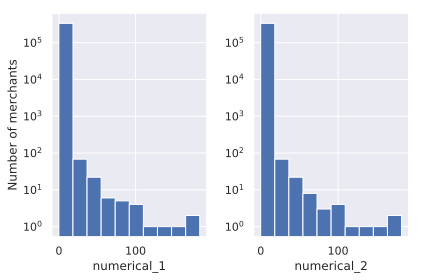

In [50]:
# Raw distributions for numerical cols
plt.figure()
plt.subplot(121)
merchants['numerical_1'].hist()
plt.yscale('log')
plt.ylabel('Number of merchants')
plt.xlabel('numerical_1')
plt.subplot(122)
merchants['numerical_2'].hist()
plt.yscale('log')
plt.xlabel('numerical_2')
plt.tight_layout()
plt.show()

Not only do the two distributions look very similar, but the two variables are highly correlated:

In [51]:
rho, pv = spearmanr(merchants['numerical_1'].values,
                    merchants['numerical_2'].values)
print('Correlation coefficient = %0.3f' % rho)

Correlation coefficient = 0.891


In fact, for 90% of the merchants, the two values are exactly the same!

In [52]:
(merchants['numerical_1'] == merchants['numerical_2']).mean()

0.8994600054387941

The `most_recent_sales_range` and `most_recent_purchases_range` contain what bin the merchant falls into in terms of recent sale amounts and purchase amounts, respectively.  There are a lot more merchants with higher category values here, suggesting the lower the category value, the higher the dollar amount (assuming the merchant-sales relationship is a log-like relationship, which is common).

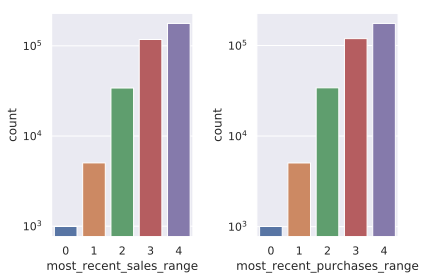

In [53]:
# most_recent_sales_range and most_recent_purchases_range
plt.figure()
plt.subplot(121)
sns.countplot(x='most_recent_sales_range',
              data=merchants)
plt.yscale('log')
plt.subplot(122)
sns.countplot(x='most_recent_purchases_range',
              data=merchants)
plt.yscale('log')
plt.tight_layout()
plt.show()

Not suprisingly, the two categorical columns are correlated - a merchant's profits likely correspond at least somewhat closely to their expenses.

In [54]:
rho, pv = spearmanr(merchants['most_recent_sales_range'].values,
                    merchants['most_recent_purchases_range'].values)
print('Correlation coefficient = %0.3f' % rho)

Correlation coefficient = 0.663


But, the categories aren't perfectly correlated:

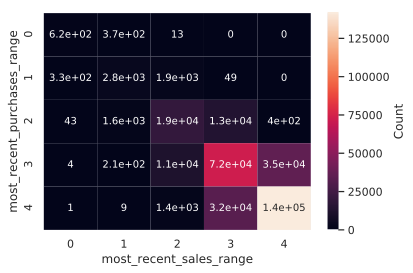

In [55]:
# Show joint counts
countplot2d('most_recent_sales_range',
            'most_recent_purchases_range',
            merchants, log=True)

The `avg_{sales,purchases}_lag{3,6,12}` columns store normalized sales and purchases in the past 3, 6, and 12 months.  During the data loading and cleaning, we took the inverse of these columns so they'd be less ridiculously skewed.  So, in the plots below, values closer to 0 indicate larger average purchases or sales.

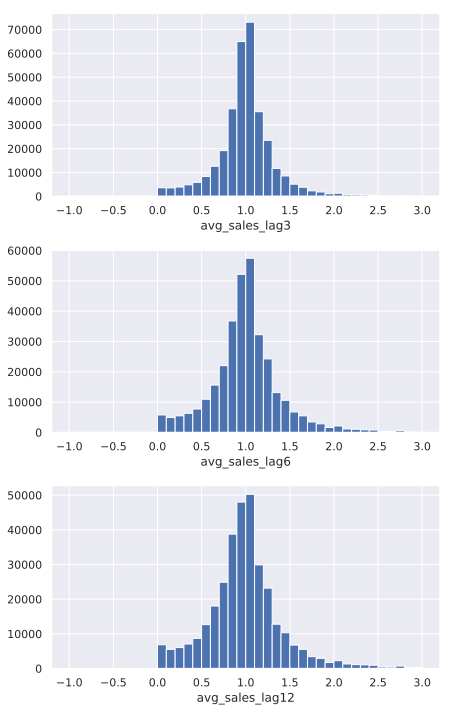

In [56]:
def plothist3(df, cols, bins=30):
    plt.figure(figsize=(6.4, 10))
    for i, lab in enumerate(cols):
        plt.subplot(3, 1, i+1)
        merchants[lab].hist(bins=bins)
        plt.xlabel(lab)
    plt.tight_layout()
    plt.show()
    
plothist3(merchants, 
          ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12'],
          bins=np.linspace(-1, 3, 41))

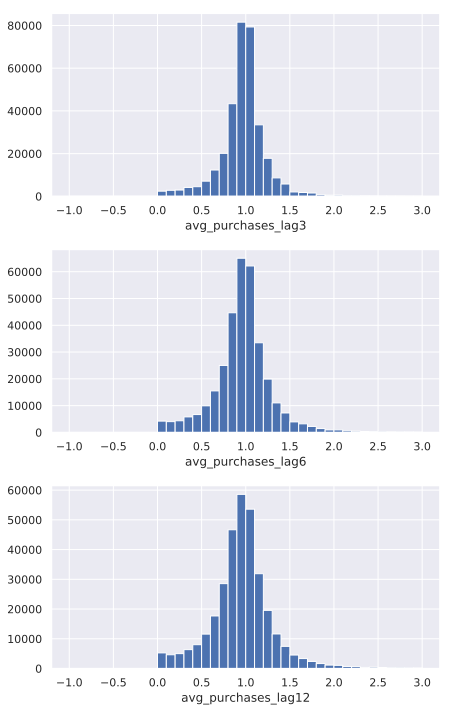

In [57]:
plothist3(merchants, 
          ['avg_purchases_lag3',
           'avg_purchases_lag6',
           'avg_purchases_lag12'],
          bins=np.linspace(-1, 3, 41))

The `active_months_lag` columns contain how many months in the past 3, 6, or 12 months the merchant has been active.  The vast majority of merchants are active every month (notice the log Y axis in the plots below), though there are arount 1,000 merchants who are only active during one or two months in the past year!

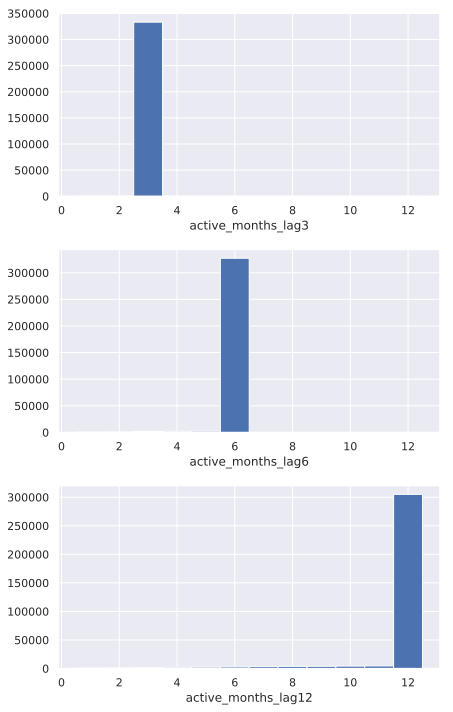

In [58]:
plothist3(merchants, 
          ['active_months_lag3',
           'active_months_lag6',
           'active_months_lag12'],
          bins=np.linspace(0.5, 12.5, 13))

The last column in the dataset is an anonymized binary column called `category_4`.

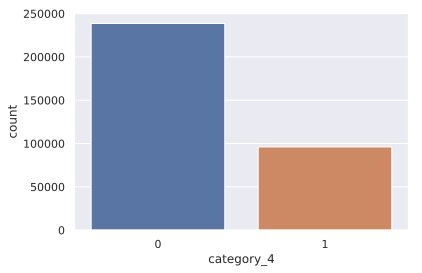

In [59]:
# category_4
sns.countplot(x='category_4', data=merchants)
plt.show()

<a id='transactions'></a>
### Transactions

Again, the transactions datasets contain records of each transaction made with a card in the cards dataset and a merchant in the merchants dataset.  They are split into two separate datasets: historical transactions and "new merchant" transactions. The "new" transactions are transactions which occurred in a period leading up to the time the loyalty score was calculated, and the historical transactions are all transactions before that (back to the start date of the datset, at least).  

To explore the transactions in the dataset collectively, here we'll merge historical and new transactions.  However, when building a predictive model, we'll want to keep them separate, so that our model is given information as to when the loyalty score was calculated.

In [60]:
# Merge new and historical transactions
trans = pd.concat([hist_trans, new_trans])

# Show info about the merged table
describe_df(trans)

Rows:    31075392
Columns: 14
Memory usage: 2050975872 Bytes
Column                Dtype           Nulls    Min                  Mean        Max                  Mode   Uniques               
authorized_flag       uint8           0        0                    0.91901     1                    1      [1 0]                 
card_id               uint32          0        0                    1.6255e+05  325539               78027  325540 unique values  
city_id               float64         2577973  1                    141.46      347                         307 unique values     
category_1            uint8           0        0                    0.069094    1                    0      [0 1]                 
installments          float64         234271   0                    0.65705     12                          13 unique values      
category_3            float32         234081   0.0                  0.53503     2.0                         [0. 1. 2.]            
merchant_category_id  

We'll take a look at the distribution of the values for each feature.  First off, the `authorized_flag` column, which stores whether the transaction was authorized or rejected.

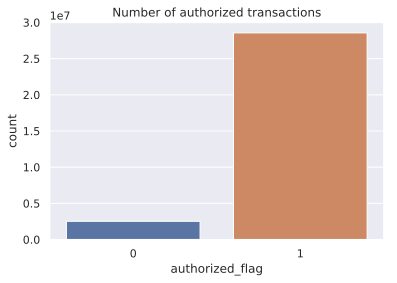

In [61]:
# authorized_flag
sns.countplot(x='authorized_flag', data=trans)
plt.title('Number of authorized transactions')
plt.show()

Most transactions were authorized, but there's a sizeable chunk of transactions which were declined.  The proportion of authorized transactions may end up being an important feature in our predictive model, seeing as card owners who are having their transactions repeatedly declined may be less "loyal" to the card company.  If there were an insignificant number of declined transactions we might just want to toss the column entirely - but, seeing as there are so many, we should keep it in case it ends up being an important predictor of loyalty.

Next, we'll look at `card_id`.  This is essentially the index of the cards dataset, so by counting the number of transactions per unique `card_id`, we can see how many transactions were made on each card.  This too seems likely to be an important feature for predicting customer loyalty.

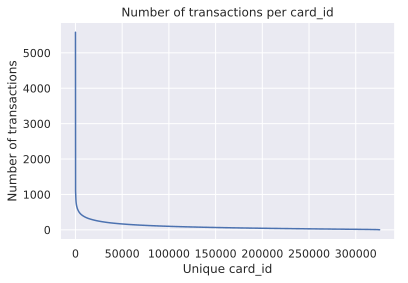

In [62]:
# card_id
plt.plot(trans['card_id'].value_counts().values)
plt.xlabel('Unique card_id')
plt.ylabel('Number of transactions')
plt.title('Number of transactions per card_id')
plt.show()

It looks like there are a few customers (`card_id`s) with a very high number of transactions but most of the `card_id`s have less than 500 or so transactions.

Let's take a look at the number of transactions per city and state.  There's one city with a very high number of transactions, but most have between 10 thousand an a million transactions (except for a few with a very low number of transactions).

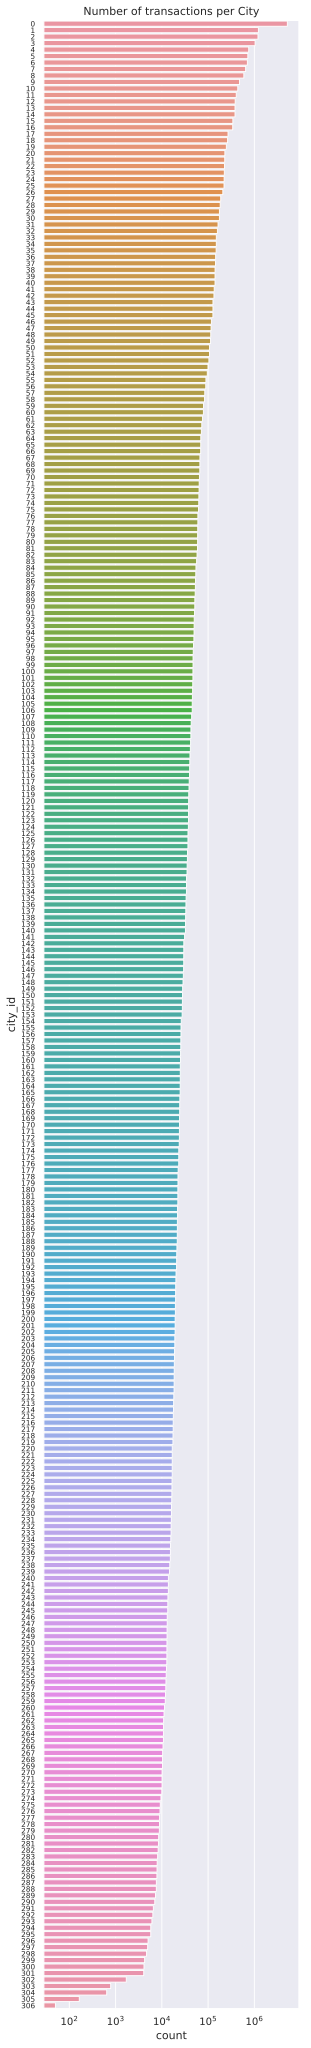

In [63]:
# city_id
plt.figure(figsize=(5, 40))
sns.countplot(y='city_id', data=trans,
              order=trans['city_id'].value_counts().index)
plt.yticks(fontsize=8)
plt.xscale('log')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.title('Number of transactions per City')
plt.show()

The number of transactions per state show a similar relationship: one state has a little over ten million transactions, and the rest have between 100 thousand and one million (except for one which has less than 10,000!).

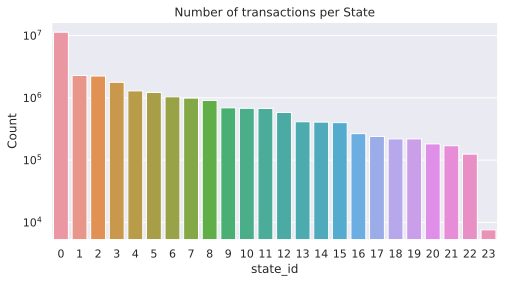

In [64]:
# state_id
plt.figure(figsize=(8, 4))
sns.countplot(x='state_id', data=trans,
              order=trans['state_id'].value_counts().index)
plt.ylabel('Count')
plt.xlabel('state_id')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.title('Number of transactions per State')
plt.show()

There are three anonymized categorical variables included in the transactions dataset: `category_1`, `category_2`, and `category_3`.  The category names are intentionally completely noninformative presumably in order to preserve either anonymity or proprietary information.  However, we can still look at the distributions for each of these three variables

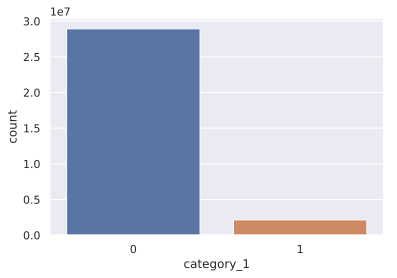

In [65]:
# category_1
sns.countplot(x='category_1', data=trans)
plt.show()

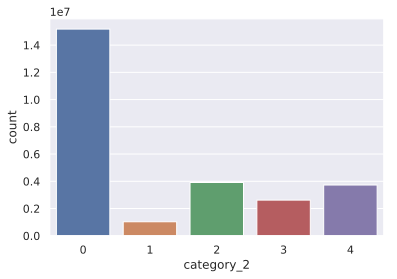

In [66]:
# category_2
sns.countplot(x='category_2', data=hist_trans)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

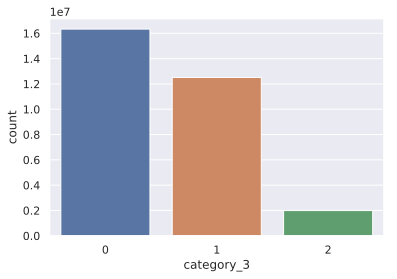

In [67]:
# category_3
sns.countplot(x='category_3', data=trans)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

Hmm, the distribution for `category_1` looks a lot like the `authorized_flag` distribution, just flipped (i.e. 1 instead of 0 and vice-versa).  Are the two features redundant?

Text(30.5, 0.5, 'category_1')

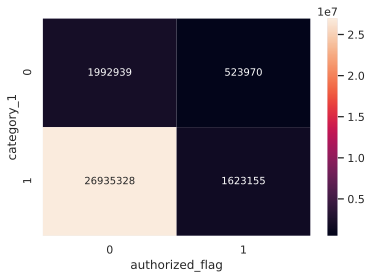

In [68]:
# Joint distribution of authorized_flag vs category_1
N, e1, e2 = np.histogram2d(trans['authorized_flag'], 
                           trans['category_1'], 
                           bins=[[-0.5, 0.5, 1.5], [-0.5, 0.5, 1.5]])
sns.heatmap(N.astype('int64'), annot=True, fmt='d')
plt.xlabel('authorized_flag')
plt.ylabel('category_1')

OK, `authorized_flag` and `category_1` aren't identical, just imbalanced in a similar way.  If they had been identical we would have wanted to remove one or the other feature.  As is, we'll keep both - especially considering we don't know what `category_1` is representing.

Next up, we'll look at the number of installments for each transaction - that is, how many payments were made in order to pay off a given purchase.

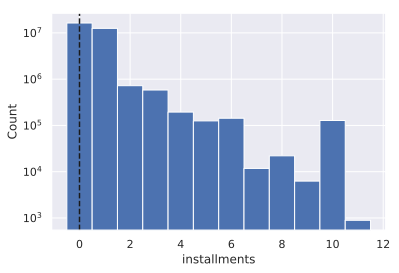

In [69]:
# installments
plt.hist(trans['installments'], bins=np.arange(-0.5, 12.5, 1.0))
plt.axvline(x=0, color='k', linestyle='--')
plt.ylabel('Count')
plt.xlabel('installments')
plt.yscale('log', nonposy='clip')
plt.show()

The maximum number of installments is only 11 because the dataset spans only one year - presumably installments are made on a monthly basis, and so no customers have made more than 11 installments over the course of the year.

The `merchant_category_id` column contains categorical information as to the type of merchant with which the transaction was made.  These categories have also been anonymized, so we have only integer values in this column, but presumably these integers correspond to merchant categories such as "fast food", "general contracting", "telecommunication", or "deparment stores".  The ids may even correspond to [merchant category codes](https://en.wikipedia.org/wiki/ISO_18245).  Let's take a look at the number of transactions per merchant category:

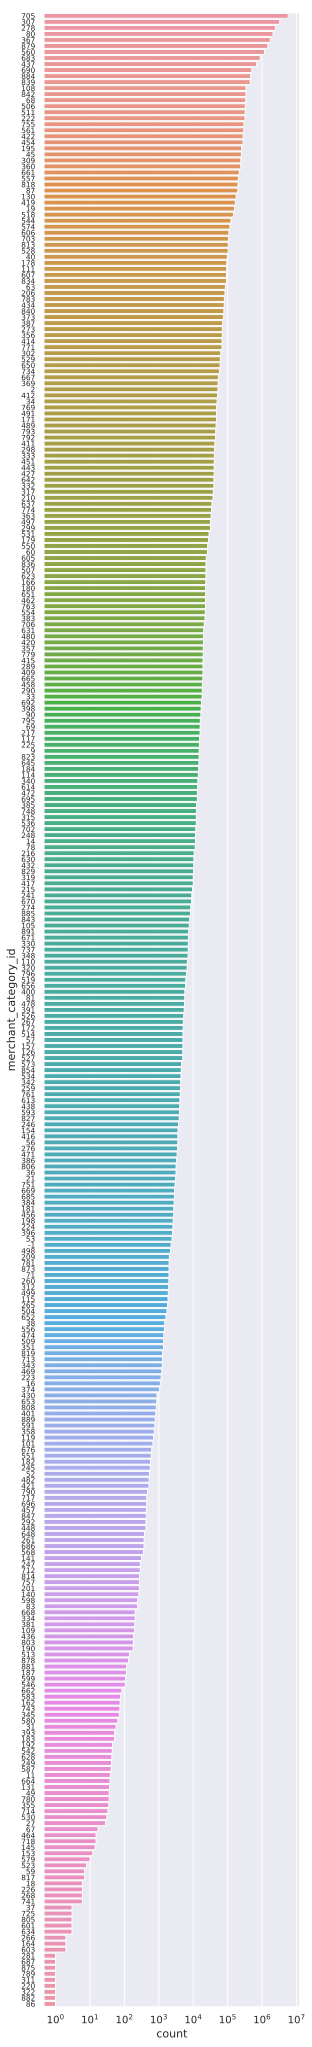

In [70]:
# merchant_category_id
plt.figure(figsize=(5, 40))
sns.countplot(y='merchant_category_id', data=trans,
              order=trans['merchant_category_id'].value_counts().index)
plt.yticks(fontsize=8)
plt.gca().set(xscale='log')
plt.show()

Similarly, the `subsector_id` likely contains information about the type of merchant with which the transaction occurred.  The value may be an anonymized version of the Brazillian equivalent of [NAICS codes](https://www.bls.gov/iag/tgs/iag_index_naics.htm).

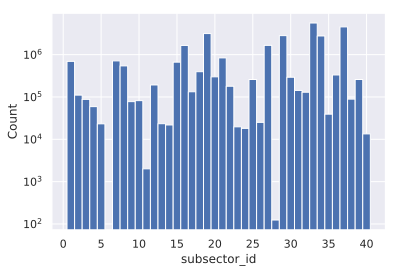

In [71]:
# subsector_id
plt.hist(hist_trans['subsector_id'], bins=np.arange(0.5, 41.5, 1.0))
plt.ylabel('Count')
plt.xlabel('subsector_id')
plt.yscale('log')
plt.show()

The `merchant_id` column contains the ID of the merchant with which the transaction occurred.  The number of transactions per merchant show a pretty clean log-log relationship (untill we get to merchants with below ~30 transactions ever):

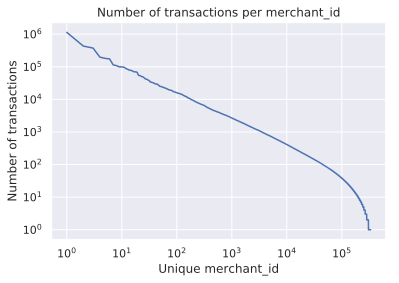

In [72]:
# merchant_id
plt.plot(np.arange(1, trans['merchant_id'].nunique()+1),
         trans['merchant_id'].value_counts().values)
plt.xlabel('Unique merchant_id')
plt.ylabel('Number of transactions')
plt.title('Number of transactions per merchant_id')
plt.xscale('log')
plt.yscale('log')
plt.show()

There's also a pretty clear log-log relationship between the number of purchases and the purchase amount, until we get to purchases with below ~10 purchases of that amount (the dollar units are normalized, so some are negative, and so I've offset the x-axis below to allow for a log x scale, and binned the purchase amounts).

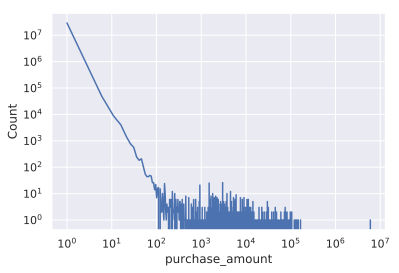

In [73]:
# purchase_amount
counts, be = np.histogram(hist_trans['purchase_amount'],
                          bins=np.arange(-1, 6010605, 5))
plt.plot(be[:-1]-min(be[:-1])+1, counts)
plt.ylabel('Count')
plt.xlabel('purchase_amount')
plt.xscale('log')
plt.yscale('log')
plt.show()

The `purchase_date` column contains when the purchase occurred.  This will likely be an important feature for our predictive model.  Card owners who use their cards regularly (or whose use is increasing) are probably more likely to have a higher loyalty score.  Also, in general, our model will need to know when each transaction occurred!  Let's take a look at how many transactions occurred as a function of the date:

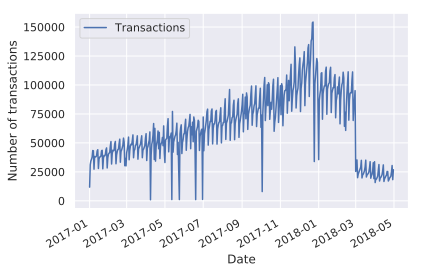

In [74]:
# Function to plot transactions over time
def transactions_over_time(df):
    tpd = pd.DataFrame()
    tpd['Transactions'] = (
        df['purchase_date'].dt.year*10000 +                    
        df['purchase_date'].dt.month*100 +                    
        df['purchase_date'].dt.day
    ).value_counts()
    tpd['Date'] = pd.to_datetime(tpd.index, format='%Y%m%d')
    tpd.plot('Date', 'Transactions')
    plt.ylabel('Number of transactions')
    plt.show()
    
# purchase_date
transactions_over_time(trans)

Huh.  The most obvious thing is the sudden dropoff in March 2018, and perhaps a smaller one in January 2018. This is actually just due to how the data has been split up in to new and historical transactions.  The historical transactions simply end mid-march:

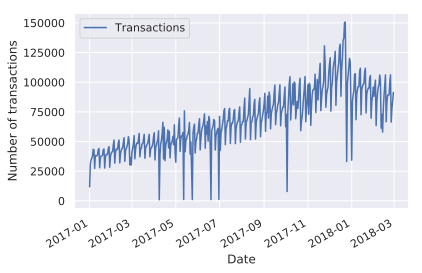

In [75]:
# purchase_date
transactions_over_time(hist_trans)

And the new transactions don't start (for most cards) until mid-march, but the number of transactions is far less.  I'm not actually sure why that is - it could be that not all new transactions were included in the dataset.

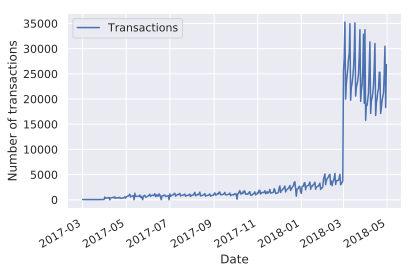

In [76]:
# purchase_date
transactions_over_time(new_trans)

The second interesting thing to notice is that there's a pretty significant weekly cycle (creating the high-frequency ups and downs in the plots above).  Looking at the number of transactions as a function of day of the week, we can see the the number of transactions ramps up over the course of the week, plummets on Sunday, and then starts climbing again on Monday.

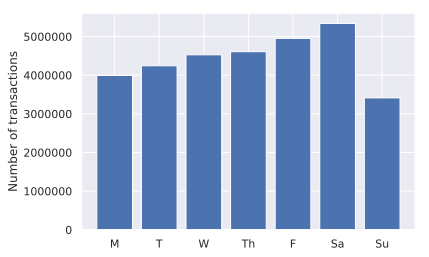

In [77]:
counts = (trans['purchase_date']
          .dt.dayofweek.value_counts())
plt.bar(x=counts.index, height=counts.values)
plt.ylabel('Number of transactions')
plt.xticks(range(7), ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su'])
plt.show()

Finally, the `month_lag` column contains the number of months between the transaction date and the time when the loyalty score was calculated.  Again, because the dataset spans only about a year, we don't see that many`month_lag`s less than -12, and none greater than 0, because the dataset doesn't include data after the loyalty score was calculated.

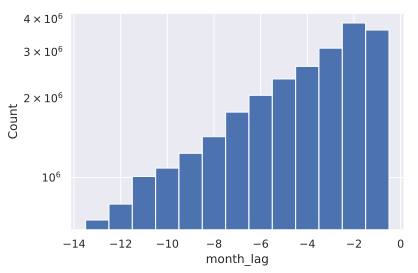

In [78]:
# month_lag
plt.hist(trans['month_lag'], bins=np.arange(-13.5, 0.5, 1.0))
plt.ylabel('Count')
plt.xlabel('month_lag')
plt.yscale('log')
plt.show()

<a id='conclusion'></a>
## Conclusion

Now that we've cleaned and gotten an understanding of the data, the next step is to connect the various data tables together and create features which a predictive model can use to predict customer loyalty.  In [the next kernel](http://www.kaggle.com/brendanhasz/elo-feature-engineering-and-feature-selection), we'll focus on feature engineering!